In [1]:
!pip install pymysql

/tmp/ipykernel_2690/1581140126.py:42: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  mysql_df = pd.read_sql(query, con=connection)


  month_of_year      category  quantity  unit_price  total_price day_of_week  \
0         April    Suspension         5        78.0        390.0      Monday   
1         March    Electrical         1        96.0         96.0    Saturday   
2          July  Transmission         5        60.0        300.0     Tuesday   
3         March    Electrical         1        48.0         48.0      Sunday   
4         March  Transmission        10        15.0        150.0      Sunday   
5           May  Transmission         8        11.0         88.0     Tuesday   
6     September  Brake System         4        34.0        136.0    Thursday   
7       October    Suspension         9        53.0        477.0     Tuesday   
8           May  Engine Parts         5        59.0        295.0   Wednesday   
9           May  Transmission         9        76.0        684.0   Wednesday   

    timestamp  
0  1682364573  
1  1679114261  
2  1690241273  
3  1677996558  
4  1679243656  
5  1683625424  
6  1695

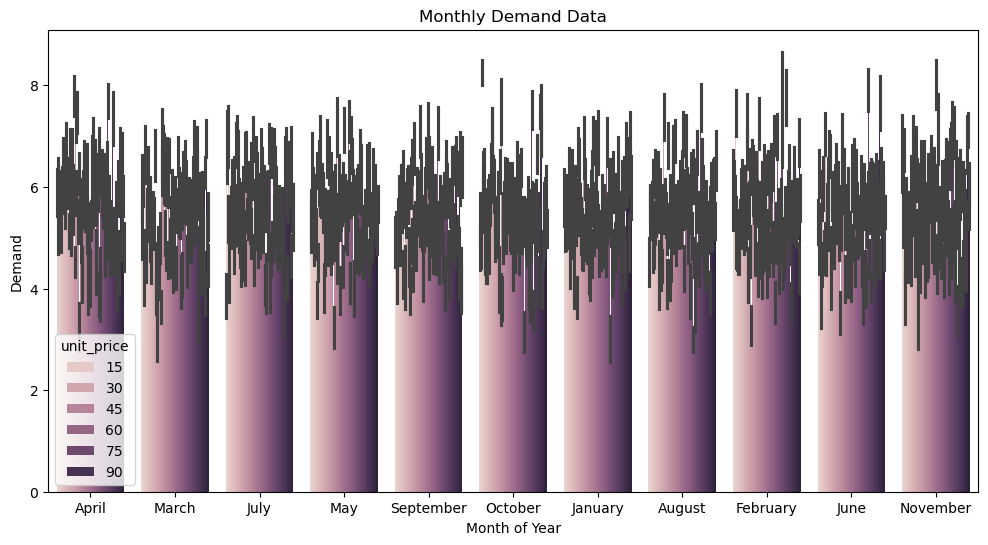

Mean Squared Error: 8.27176098501116


Loading BokehJS ...

In [2]:
from bokeh.plotting import figure, show,curdoc
from bokeh.palettes import Category10_10
from bokeh.transform import factor_cmap
from bokeh.io import output_notebook, show
from bokeh.models import NumeralTickFormatter
from bokeh.models import ColumnDataSource
from bokeh.layouts import column
from bokeh.io import output_file, save



import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import calendar  # Import the calendar module for month name conversion
import pymysql  # Import pymysql module for MySQL connection

# MySQL connection properties
mysql_host = "mysql"
mysql_port = 3306
mysql_user = "myuser"
mysql_password = "mypassword"
mysql_db = "mydatabase"

# Connect to MySQL using pymysql
connection = pymysql.connect(
    host=mysql_host,
    port=mysql_port,
    user=mysql_user,
    password=mysql_password,
    database=mysql_db
)

# The rest of your code...


# Fetch data from MySQL with the additional feature
query = "SELECT month_of_year,category,quantity, unit_price, total_price, day_of_week, timestamp FROM sales_data"
mysql_df = pd.read_sql(query, con=connection)

# Close MySQL connection
connection.close()

# Convert integer months to month names
mysql_df['month_of_year'] = mysql_df['month_of_year'].apply(lambda x: calendar.month_name[x])

# Explore the data
print(mysql_df.head(10))

# Visualize the data using a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='month_of_year', y='quantity', data=mysql_df, hue='unit_price')
plt.title('Monthly Demand Data')
plt.xlabel('Month of Year')
plt.ylabel('Demand')
plt.show()

# Convert month names to integer months
month_name_to_int = {month: i for i, month in enumerate(calendar.month_name[1:], start=1)}
mysql_df['month_of_year'] = mysql_df['month_of_year'].apply(lambda x: month_name_to_int[x])

# Prepare data for modeling
X = mysql_df[['month_of_year', 'unit_price','timestamp']]
y = mysql_df['quantity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Bokeh plot function
def create_bokeh_plot(x_range, data, x_label, y_label, title, color):
    p = figure(x_range=x_range, height=350, title=title, x_axis_label=x_label, y_axis_label=y_label)
    p.vbar(x=x_range, top=data, width=0.9, line_color="white", fill_color=color)
    p.xaxis.major_label_orientation = "vertical"
    show(p)

days_of_week = mysql_df['day_of_week'].unique()

# Bokeh plots
output_notebook()

# Plot the relationship between day of the week and quantity sold
create_bokeh_plot(days_of_week, mysql_df['quantity'], 'Day of the Week', 'Quantity Sold', 'Relationship between Day of the Week and Quantity Sold', 'orange')

# Plot total sales by day of the week
day_of_week_sales = mysql_df.groupby('day_of_week')['total_price'].sum().reset_index()
create_bokeh_plot(day_of_week_sales['day_of_week'], day_of_week_sales['total_price'], 'Day of the Week', 'Total Sales by Day of the Week', 'Total Sales by Day of the Week', 'orange')

# Plot total sales by category in descending order
category_sales = mysql_df.groupby('category')['total_price'].sum().reset_index().sort_values(by='total_price', ascending=False)
create_bokeh_plot(category_sales['category'], category_sales['total_price'], 'Category', 'Total Sales', 'Total Sales by Category (Descending Order)', 'orange')

# Extract hour from the timestamp
mysql_df['hour'] = pd.to_datetime(mysql_df['timestamp'], unit='s').dt.hour

# Group by hour and calculate total sales for each hour
hourly_sales = mysql_df.groupby('hour')['total_price'].sum().reset_index()

# Plot hourly sales
create_bokeh_plot(list(map(str, hourly_sales['hour'])), hourly_sales['total_price'], 'Hour of the Day', 'Total Sales', 'Hourly Sales', 'orange')
